# Machine Learning project 

This notebook is a short version of the [end-to-end Machine Learning project](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) provided by Aurélien Geron.

## Setup

This project requires: 

- Python 3.7 or above
- Scikit-Learn ≥ 1.0.1:

In [95]:
%matplotlib inline

import sys
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import sklearn
from sklearn import set_config
set_config(display='diagram')

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Check if you have the correct versions
assert sklearn.__version__ >= "1.0.1"
assert sys.version_info >= (3, 7)

## Data

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

In [96]:
housing = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/housing_hml3.csv")

### Overview

In [97]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [98]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [99]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [100]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


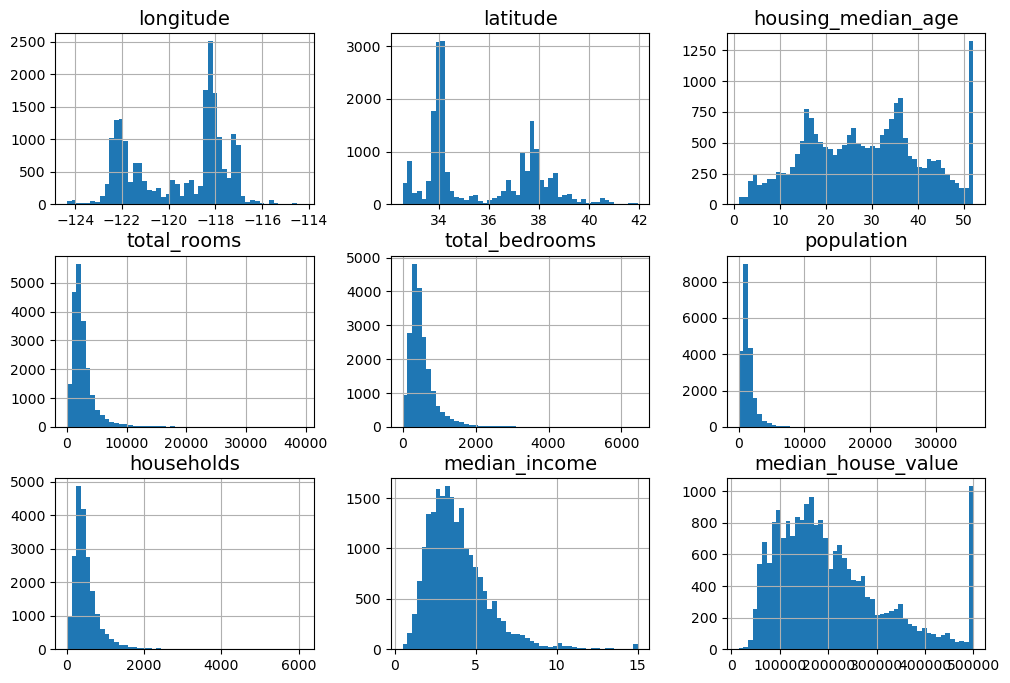

In [101]:
housing.hist(bins=50, figsize=(12, 8));

### Data split

In [102]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

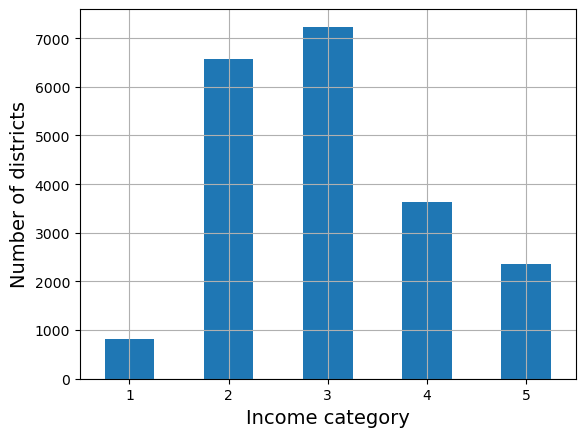

In [103]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

plt.xlabel("Income category")
plt.ylabel("Number of districts");

Stratified split:

In [104]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Drop the variable "income_cat" from our datasets:

In [105]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Exploration

In [106]:
housing = strat_train_set.copy()

#### Visualizing Geographical Data

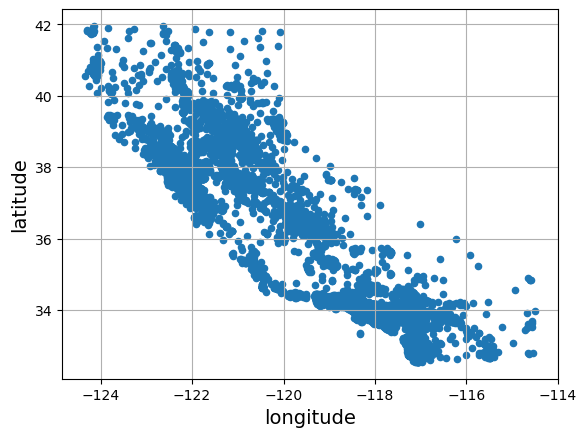

In [107]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True);

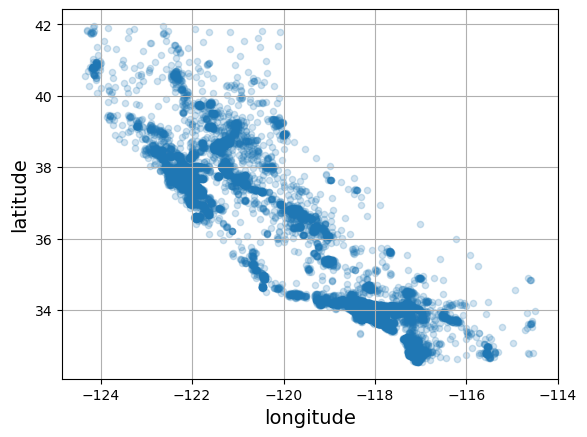

In [108]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2);

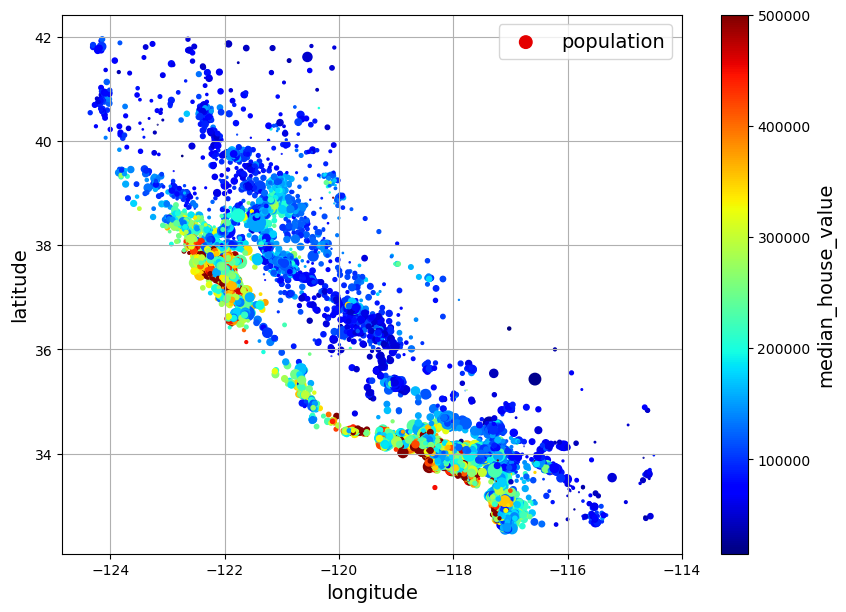

In [109]:
housing.plot(kind="scatter", 
             x="longitude", 
             y="latitude", 
             grid=True,
             s=housing["population"] / 100, 
             label="population",
             c="median_house_value", 
             cmap="jet", 
             colorbar=True,
             legend=True, 
             sharex=False, 
             figsize=(10, 7)
             );

The argument `sharex=False` fixes a display bug: without it, the x-axis values and label are not displayed (see: https://github.com/pandas-dev/pandas/issues/10611).

### Correlations

In [110]:
corr_matrix = housing.corr()

In [111]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

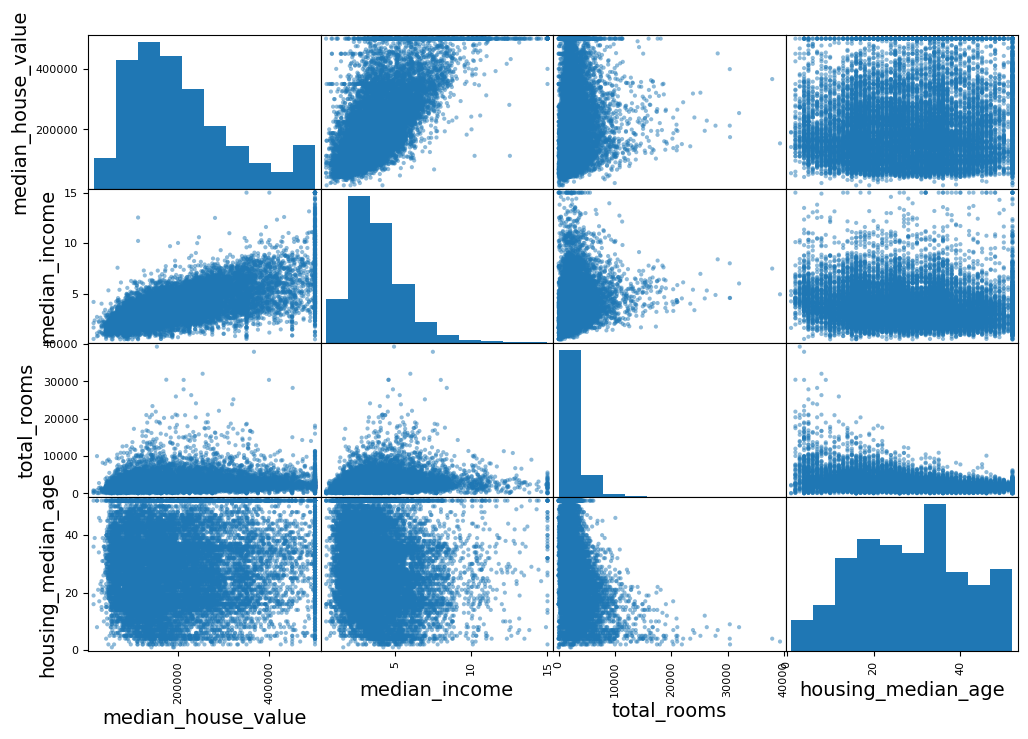

In [112]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8));

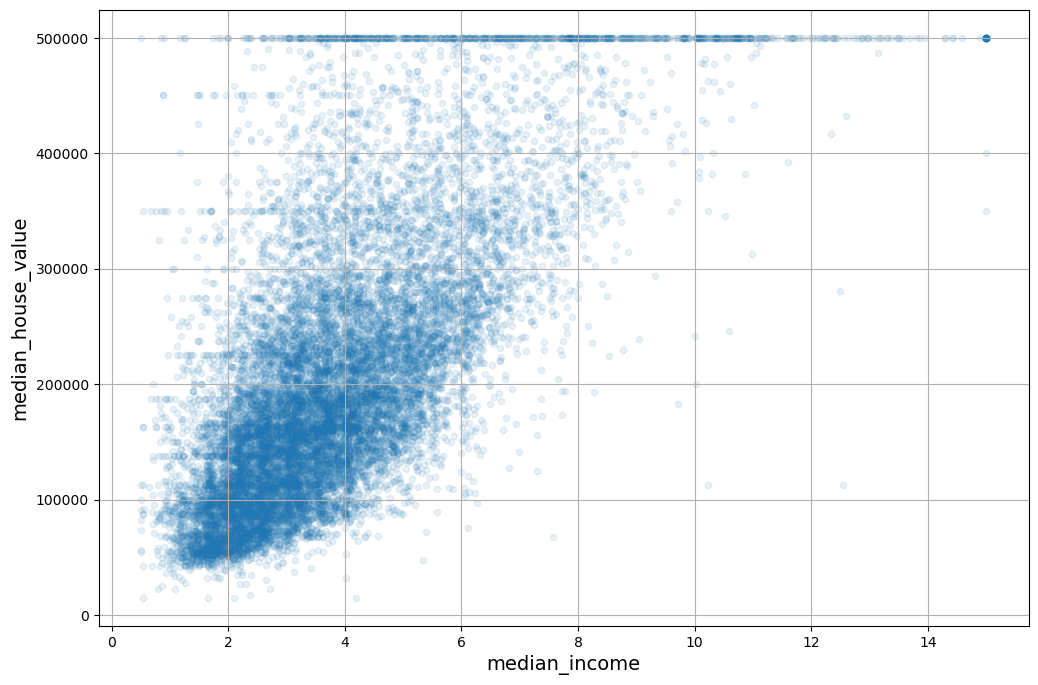

In [113]:
housing.plot(kind="scatter", 
             x="median_income", 
             y="median_house_value",
             alpha=0.1, 
             grid=True,
             figsize=(12, 8));

### Feature Engineering

Experimenting with Attribute Combinations

In [114]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [115]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

## Data Pipeline

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [116]:
housing = strat_train_set.drop("median_house_value", axis=1)

housing_labels = strat_train_set["median_house_value"].copy()

Now let's build a pipeline to preprocess the attributes:

In [117]:
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
               
cat_attribs = ["ocean_proximity"]

In [118]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
    )

In [119]:
# default numerical pipeline
from sklearn.preprocessing import StandardScaler

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
    )

In [120]:
# custom function to make ratios
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

In [121]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

# custom function to transfomr ratios
def ratio_pipeline(name=None):
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio),
        StandardScaler())

In [122]:
# custom log transformer
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log),
    StandardScaler())

- To learn more about developing scikit-learn estimators, take a look at [this page](https://scikit-learn.org/stable/developers/develop.html)

- Here is a template to build your own scikit-learn functions: [template](https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py)

In [123]:
# custom cluster similarity  
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [124]:
# custom cluster similarity step 
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

Perform transformations:

In [125]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector


preprocessing = ColumnTransformer([
        ("bedrooms_ratio", ratio_pipeline("bedrooms_ratio"),
                           ["total_bedrooms", "total_rooms"]),

        ("rooms_per_house", ratio_pipeline("rooms_per_house"),
                            ["total_rooms", "households"]),

        ("people_per_house", ratio_pipeline("people_per_house"),
                             ["population", "households"]),

        ("log", log_pipeline, ["total_bedrooms", "total_rooms",
                               "population", "households", "median_income"]),

        ("geo", cluster_simil, ["latitude", "longitude"]),
        
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [126]:
housing_prepared = preprocessing.fit_transform(housing)

housing_prepared.shape

(16512, 24)

## Models

### Linear Regression

In [127]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(
            preprocessing, 
            LinearRegression()
            )

In [128]:
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function column_ratio at 0x186eac9d...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x186e9fd30>)])),
                ('linearregression', LinearRegression())])

In [129]:
housing_predictions = lin_reg.predict(housing)

In [130]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

68695.46147809878

Let's try the full preprocessing pipeline on a few training instances:

In [131]:
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([244400., 371700., 128400.,  94700., 328200.])

Compare against the actual values:

In [132]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [133]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.7%, -23.2%, 26.3%, -1.5%, -9.3%


### Decision Tree

In [134]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(
    preprocessing, 
    DecisionTreeRegressor(random_state=42)
    )

In [135]:
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function column_ratio at 0x186eac9d...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x186e9fd30>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [136]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

## Cross-Validation

### Decision Tree

In [137]:
from sklearn.model_selection import cross_val_score

# we only use cv=3 instead of cv=10 to speed up the computation
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=3)

In [138]:
pd.Series(tree_rmses).describe()

count        3.000000
mean     68282.891053
std       1486.492256
min      66810.075215
25%      67532.990434
50%      68255.905652
75%      69019.298971
max      69782.692291
dtype: float64

### Linear Regression

In [139]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=3)

pd.Series(lin_rmses).describe()

count        3.000000
mean     69778.756842
std       1629.907725
min      67980.530959
25%      69088.686886
50%      70196.842814
75%      70677.869784
max      71158.896754
dtype: float64

### Random Forest

Again, we set cv=3 instead of cv=10:

In [140]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
                           
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=3)

In [141]:
pd.Series(forest_rmses).describe()

count        3.000000
mean     47889.465303
std        619.080587
min      47392.624982
25%      47542.700149
50%      47692.775316
75%      48137.885464
max      48582.995613
dtype: float64

Let's compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error"):

In [142]:
forest_reg.fit(housing, housing_labels)

housing_predictions = forest_reg.predict(housing)

forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

17474.619286483998

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

## Fine-Tuning

### Grid Search

In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

In [144]:
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

In [145]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')


**Warning:** the following cell may take a few minutes to run:

In [146]:
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<function...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x186e9fd30>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

You can get the full list of hyperparameters available for tuning by looking at `full_pipeline.get_params().keys()`:

In [151]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__be

The best hyperparameter combination found:

In [152]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [153]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function column_ratio at 0x186eac9d0>))...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x186ef0250>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

Let's look at the score of each hyperparameter combination tested during the grid search:

In [154]:
cv_res = pd.DataFrame(grid_search.cv_results_)

cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)


In [155]:

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", 
                 "split0_test_score",
                 "split1_test_score", 
                 "split2_test_score", 
                 "mean_test_score"]]


In [156]:
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]

cv_res.columns = ["n_clusters", "max_features"] + score_cols

cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


### Randomized Search

In [157]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

**Warning:** the following cell may take a few minutes to run:

Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:

In [158]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=10),
                  'random_forest__max_features': randint(low=2, high=10)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)


rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms_ratio',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(func=<fu...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x186e9fd30>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x186f11a00>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x186ec66a0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [159]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)

cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]

cv_res.columns = ["n_clusters", "max_features"] + score_cols

cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
0,9,5,45311,44727,46099,45379
4,9,3,45721,45397,46743,45953
7,7,5,45887,45597,46504,45996
3,7,6,45633,45815,46702,46050
1,7,8,45887,45820,46809,46172


### Analyze Errors

Analyze Errors of Best Model

In [160]:
final_model = rnd_search.best_estimator_  # includes preprocessing

feature_importances = final_model["random_forest"].feature_importances_

feature_importances.round(2)

array([0.08, 0.06, 0.08, 0.01, 0.01, 0.01, 0.01, 0.25, 0.04, 0.03, 0.04,
       0.03, 0.04, 0.06, 0.02, 0.03, 0.02, 0.01, 0.12, 0.  , 0.  , 0.01,
       0.03])

## Evaluate on Test Set

In [161]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [162]:
final_predictions = final_model.predict(X_test)

In [163]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

44556.01747258438


We can compute a 95% confidence interval for the test RMSE:

In [164]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([42373.48736315, 46636.51953908])

## Save model

Model persistence using joblib

Save the final model:

Note that the model is pretty huge:

In [165]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Now you can deploy this model to production. For example, the following code could be a script that would run in production:

In [166]:
final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts

predictions = final_model_reloaded.predict(new_data)

In [167]:
predictions

array([429545.11      , 462980.09      , 108348.47761194,  99628.        ,
       345977.07      ])

## Exercise solutions

### 1. Support Vector Machine

Exercise: _Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best `SVR` predictor perform?_

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])

grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<function...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x17f06eaf0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

The best model achieves the following score (evaluated using 3-fold cross validation):

In [70]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

69814.13878034828

That's much worse than the `RandomForestRegressor` (but to be fair, we trained the model on much less data). Let's check the best hyperparameters found:

In [71]:
grid_search.best_params_

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

### 2. Randomized Search CV

Exercise: _Try replacing the `GridSearchCV` with a `RandomizedSearchCV`._

**Warning:** the following cell will take several minutes to run. You can specify `verbose=2` when creating the `RandomizedSearchCV` if you want to see the training details.

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': reciprocal(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

# we set n_iter to 10 
rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=10, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)

rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms_ratio',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(func=<fu...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x17f06eaf0>)])),
                                             ('svr', SVR())]),
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17ebcf070>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17ebf1be0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

The best model achieves the following score (evaluated using 3-fold cross validation):

In [73]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

55853.881003350914

Now that's really much better, but still far from the `RandomForestRegressor`'s performance. Let's check the best hyperparameters found:

In [74]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Note that we used the `expon()` distribution for `gamma`, with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [75]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)  # get 100,000 samples
((s > 0.105) & (s < 2.29)).sum() / 100_000

0.80066

We used the `reciprocal()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

### 3. SelectFromModel

Exercise: _Try adding a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes._

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a `SelectFromModel` transformer based on a `RandomForestRegressor` before the final regressor:

In [76]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [77]:
selector_rmses = -cross_val_score(selector_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)

In [78]:
 pd.Series(selector_rmses).describe()

count        3.000000
mean     56211.362089
std       1922.002815
min      54150.008611
25%      55339.929912
50%      56529.851213
75%      57242.038829
max      57954.226445
dtype: float64

Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tuning it using random search or grid search?

Congratulations! You already know quite a lot about Machine Learning. :)